## Import

Packages used in this notebook are imported.

In [ ]:
#dataframes and arrays 
import pandas as pd 
import numpy as np

#plotting 
import matplotlib.pyplot as plt

#building & fitting the model 
import tensorflow as tf 
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential 
import jax

#fine tuning
from tensorflow.keras.callbacks import LearningRateScheduler

#miscellanous 
import math 
import time

In [ ]:
tf.keras.backend.clear_session()    #clear out any unnecessary memory by clearing unused layers/models
print(tf.__version__)     #check tensorflow version

2.11.0


## Data


First, the dataset is loaded into the workspace

In [ ]:
#mount Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#set the working directory to where the data is stored
%cd /content/drive/MyDrive/dataset/DSA4212/assignment_1

/content/drive/MyDrive/dataset/DSA4212/assignment_1


In [ ]:
class_names=["fish", "dog", "device", "chainsaw", "church", "horn", "truck", "petrol", "golf", "parachute"]

# load data -- be patient, does take a few secs
data_train_all = np.load("assignment_1_train.npz")
data_test = np.load("assignment_1_test.npz")

train_size = data_train_all["img"].shape[0]           #size of initial training dataset is store (to help in train-validation split later) 

#labels converted to integer for one-hot encoding 
Y_train_all = data_train_all["label"].astype(int)
Y_test = data_test["label"].astype(int)

The class labels are one-hot encoded in order to be able to apply label smoothing later.

In [ ]:
Y_train = jax.nn.one_hot(Y_train_all,10)
Y_test = jax.nn.one_hot(Y_test,10)

Initial training data is split the training data into training and validation data, both of which are read into TensorFlow batches.


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((data_train_all["img"], Y_train))
test_ds = tf.data.Dataset.from_tensor_slices((data_test["img"], Y_test))

#shuffle the data and take 20% of training data as validation
train_ds = train_ds.shuffle(train_size, reshuffle_each_iteration = False)
val_ds = train_ds.take(train_size//5)
train_ds = train_ds.skip(train_size//5)

train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)
test_ds = test_ds.batch(32)

Allow prefetching so that while the previous batch is being trained, the next batch is parallely read into the model, reducing the overall training time. 

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(9999).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Functions
A function plot_accuracy_loss is defined to visualise our model accuracy and loss later.




In [ ]:
plt.style.use('ggplot')
def plot_accuracy_loss(fit_history): 
  #extract the training and validation accuracy values
  train_acc = fit_history.history['accuracy']
  val_acc = fit_history.history['val_accuracy']

  #extract the training and validation loss values
  train_loss = fit_history.history['loss']
  val_loss = fit_history.history['val_loss']

  num_epochs = len(fit_history.history['val_accuracy'])
  x_range = range(num_epochs)
  
  acc_lower_range = math.floor(min(train_acc + val_acc)/0.05) * 0.05
  acc_upper_range = math.ceil((max(train_acc + val_acc)+0.05)/0.05) * 0.05
  loss_lower_range = math.floor(min(train_loss + val_loss)/0.05) * 0.05
  loss_upper_range = math.ceil((max(train_loss + val_loss)+0.05)/0.05) * 0.05

  #Plot the training and accuracy values over the number of epochs 
  plt.figure(figsize=(10, 8))
  plt.subplot(1, 2, 1)
  plt.plot(x_range, train_acc, label='Training Accuracy')
  plt.plot(x_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')
  plt.xticks(np.arange(min(x_range), max(x_range)+1, 5))
  plt.yticks(np.arange(acc_lower_range, acc_upper_range, 0.05))

  #Plot the training and accuracy loss over the number of epochs 
  plt.subplot(1, 2, 2)
  plt.plot(x_range, train_loss, label='Training Loss')
  plt.plot(x_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xticks(np.arange(min(x_range), max(x_range)+1, 5))
  plt.yticks(np.arange(loss_lower_range, loss_upper_range, 0.05))
  
  plt.show()

# Model
The layers of the model are defined, starting with rescaling the data to be within the range [0,1], followed by 3 pairs of convolution-max pooling layers, and then ending with global averag pooling, dense and softmax layers.

Note that 
<br> 1) the inputs to convolutional layers are padded to ensure input and output are of the same size 
<br> 2) convolution layers are implemented with ReLU activation 
<br> 3) the Dense FC layer is implemented with tanh activation
<br> 4) the weights of each convolutional layers are initialized with He Uniform. 

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(128, 128, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer = 'he_uniform'),         
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer = 'he_uniform'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu', kernel_initializer = 'he_uniform'),
  layers.MaxPooling2D(),
  layers.GlobalAveragePooling2D(),
  layers.Dense(128, activation='tanh'),
  layers.Dense(num_classes, activation ='softmax')
])

The learning rate decay function is defined as follows:

In [ ]:
def exp_decay(epoch, lr):
  if epoch < 5:                         #first 5 epochs no decay
    return lr
  elif epoch <=10:                      #6-10 epochs: decay with exp(-0.1)
    return lr*tf.math.exp(-0.1)
  elif epoch <=16:                      #10-16 epochs: decay with exp(-0.15)
    return lr*tf.math.exp(-0.15)
  else:                                 #17 epochs onward: decay with exp(-0.2)
    return lr*tf.math.exp(-0.2)

#implemented via a learning rate scheduler callback during the training period
lrate = LearningRateScheduler(exp_decay)

The model is compiled as follows. Label smoothing is used in calculating the cross-entropy loss: the correct class label is given a confidence of 0.82 and the other class labels are given confidence of 0.02.

In [ ]:
model.compile(
    loss=tf.losses.CategoricalCrossentropy(label_smoothing = 0.2),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0028),
    metrics=['accuracy']
  )

The model is then trained for 23 epochs and the training period is also timed for how long it takes.

In [ ]:
epochs = 23

start = time.time()
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs,
    callbacks = [lrate]
)
end = time.time()

Epoch 1/23
233/233 [==============================] - 6s 19ms/step - loss: 2.0362 - accuracy: 0.3390 - val_loss: 1.8161 - val_accuracy: 0.5078 - lr: 0.0028
Epoch 2/23
233/233 [==============================] - 4s 17ms/step - loss: 1.7536 - accuracy: 0.5341 - val_loss: 1.6612 - val_accuracy: 0.5960 - lr: 0.0028
Epoch 3/23
233/233 [==============================] - 5s 20ms/step - loss: 1.6537 - accuracy: 0.5935 - val_loss: 1.6416 - val_accuracy: 0.6014 - lr: 0.0028
Epoch 4/23
233/233 [==============================] - 4s 17ms/step - loss: 1.5737 - accuracy: 0.6364 - val_loss: 1.6014 - val_accuracy: 0.6003 - lr: 0.0028
Epoch 5/23
233/233 [==============================] - 4s 17ms/step - loss: 1.5075 - accuracy: 0.6784 - val_loss: 1.5140 - val_accuracy: 0.6799 - lr: 0.0028
Epoch 6/23
233/233 [==============================] - 4s 19ms/step - loss: 1.4673 - accuracy: 0.6976 - val_loss: 1.4688 - val_accuracy: 0.6928 - lr: 0.0025
Epoch 7/23
233/233 [==============================] - 4s 17ms/st

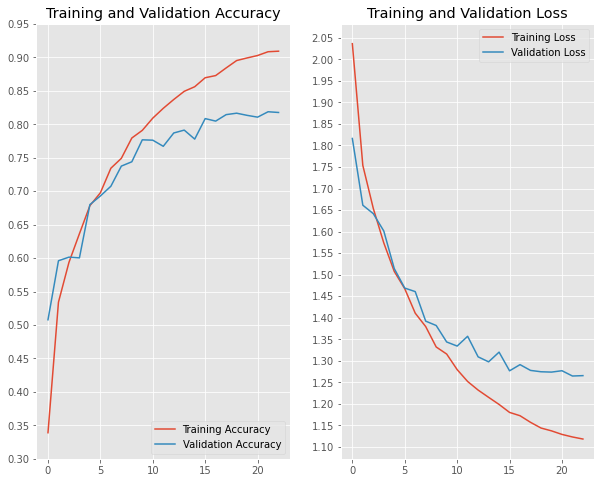

121/121 [==============================] - 1s 8ms/step - loss: 1.2912 - accuracy: 0.8055
Test accuracy:  0.805497944355011
Time taken:  110.99663233757019


In [ ]:
plot_accuracy_loss(history)
print("Test accuracy: ", model.evaluate(test_ds)[1])
print("Time taken: ", end-start)

The model achieves a validation accuracy of 0.8176 and a test accuracy of 0.8055. The validation curves also look fairly smooth, without running into overfitting (also supported by the closeness of validation and test accuracies).